In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import re
import numpy as np

from collections import Counter

plt.style.use('ggplot')

In [2]:
df = pd.read_csv('tweets.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17410 entries, 0 to 17409
Data columns (total 8 columns):
name              17410 non-null object
username          17410 non-null object
description       14728 non-null object
location          11432 non-null object
followers         17410 non-null int64
numberstatuses    17410 non-null int64
time              17410 non-null object
tweets            17410 non-null object
dtypes: int64(2), object(6)
memory usage: 1.1+ MB


In [4]:
df = df.replace(np.nan, 'missing', regex=True)

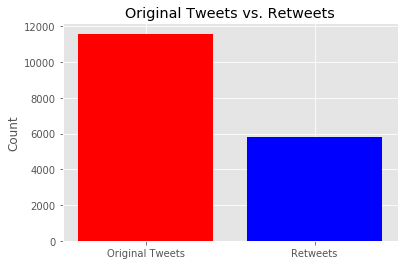

Original:  11584
Retweets:  5826


In [5]:
retweets = []
original_tweets = []

for user, tweet in zip(df['username'], df['tweets']):
    match = re.search(r'^\bRT\b', tweet)
    if match == None:
        original_tweets.append([user,tweet])
    else:
        retweets.append([user,tweet])   

original_tweets = np.array(original_tweets)
retweets = np.array(retweets)

plt.bar([1,2], [len(original_tweets[:,1]), len(retweets[:,1])], align='center', color=['r', 'b'])

ax = plt.gca()
ax.set_ylabel('Count')
ax.set_xticks([1,2])
ax.set_xticklabels(['Original Tweets', 'Retweets'])
ax.set_title('Original Tweets vs. Retweets')

plt.show()

print("Original: ", len(original_tweets[:,1]))
print("Retweets: ", len(retweets[:,1]))

In [6]:
all_tweets = []
for user, tweet in zip(df['username'], df['tweets']):
    all_tweets.append([user, tweet])

In [7]:
in_set = []
not_in_set = []

for record in all_tweets:
    match = re.findall(r'@\w*', record[1])
    if match != []:
        for name in match:
            if (name[1:] in df['username'].unique()) and (record[0] != name[1:]): 
                in_set.append([record[0], name[1:]]) #sender & receiver appended
            elif record[0] != name[1:]:
                not_in_set.append([record[0], name[1:]]) #sender & receiver appended

in_set = np.array(in_set) 
not_in_set = np.array(not_in_set)

print("Tagged users in set: ", len(np.unique(in_set[:,1])))
print("Tagged users not in set: ", len(np.unique(not_in_set[:,1])))
print("Total users in set: ", len(df['username'].unique()))

Tagged users in set:  64
Tagged users not in set:  3222
Total users in set:  112


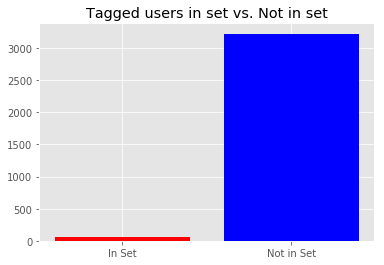

In [8]:
plt.bar([1,2], [len(np.unique(in_set[:,1])), len(np.unique(not_in_set[:,1]))], align='center', color=['r','b'])

labels=['In Set', 'Not in Set']
plt.xticks([1,2], labels)

plt.title('Tagged users in set vs. Not in set')
plt.show()

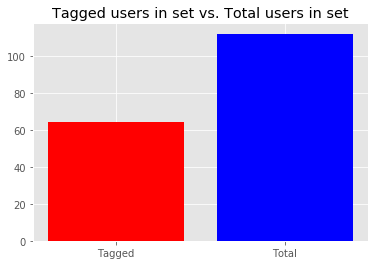

In [9]:
plt.bar([1,2], [len(np.unique(in_set[:,1])), len(df['username'].unique())], align='center', color=['r','b'])

labels=['Tagged', 'Total']
plt.xticks([1,2], labels)

plt.title('Tagged users in set vs. Total users in set')
plt.show()

## Wordcloud of Tweets

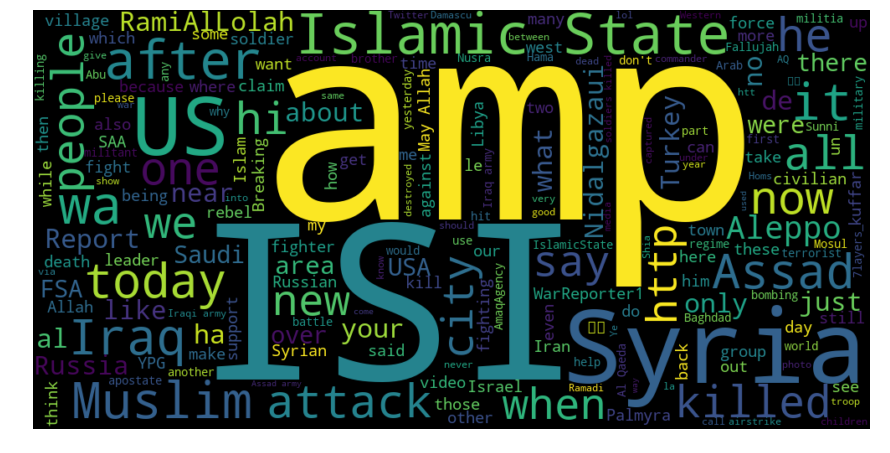

In [10]:
from wordcloud import WordCloud

stopwords = ['https', 'the', 'in', 'to', 'RT', 'is', 'of', 'and', 'you', 'their', 'on', 'that', 'it', 'by', 'with', 'from', 'are', 'for', 'have', 'will', 'they', 'who', 'thi', 'this', 'co', 'be', 'or', 'as', 'so', 'but', 'not', 'an', 'if', 'them', 'it', 'at']

wordcloud = WordCloud(width = 1000, height = 500, stopwords=stopwords).generate(' '.join(df['tweets'].tolist()))

plt.figure(figsize=(15,8))

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis("off")

plt.show()

## Worldcloud of user descriptions

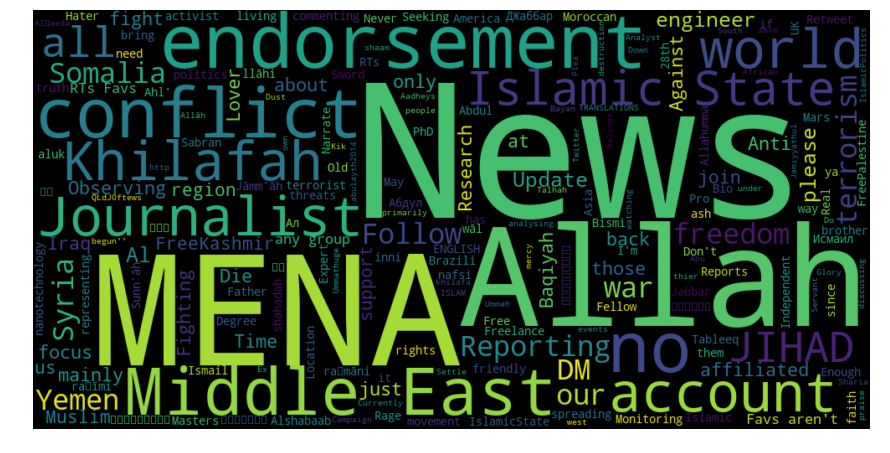

In [11]:
from wordcloud import WordCloud

df1 = df['description'].drop_duplicates()

stopwords = ['https', 'the', 'in', 'to', 'RT', 'is', 'of', 'and', 'you', 'their', 'on', 'that', 'it', 'by', 'with', 'from', 'are', 'for', 'have', 'will', 'they', 'who', 'thi', 'this', 'co', 'be', 'or', 'as', 'so', 'but', 'not', 'an', 'also', 'me', 'we', 'missing', 'My', 'your']

wordcloud = WordCloud(width = 1000, height = 500, stopwords=stopwords).generate(' '.join(df1.tolist()))

plt.figure(figsize=(15,8))

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis("off")

plt.show()

In [12]:
tweeter_tagged = []

for record in all_tweets:
    match = re.findall(r'@\w*', record[1])
    if match != []:
        for name in match:
            tweeter_tagged.append([record[0], name[1:]])

tweeter_tagged = np.array(tweeter_tagged)

## Graph all tweeters listed in the dataset and additional users tagged in a given tweet

In [13]:
graph2 = nx.Graph()

all_users = list(set(tweeter_tagged[:,0]) | set(tweeter_tagged[:,1]))
graph2.add_nodes_from(all_users, count=10)
node_colours = []

for node in graph2.nodes():
    if node in (set(tweeter_tagged[:,0]) & set(tweeter_tagged[:,1])):
        node_colours.append('g') #tweeters & those tagged
    elif node in np.unique(tweeter_tagged[:,0]):
        node_colours.append('r') #only tweeters
    elif node in np.unique(tweeter_tagged[:,1]):
        node_colours.append('b') #only those who were tagged

In [14]:
edges = {}
occurrence_count = Counter(map(tuple, tweeter_tagged))
for (tweeter, tagged), count in occurrence_count.items():
    if (tagged, tweeter) in edges.keys():
        edges[(tagged, tweeter)] = edges[(tagged, tweeter)] + count
    else:
        edges[(tweeter, tagged)] = count
        
for (tweeter, tagged), count in edges.items():
    graph2.add_edge(tweeter, tagged, weight=count)
    
followers2 = {}
tweet_num2 = {}

for username in all_users:
    followers2[username] = df[df['username'] == username]['followers'].unique()
    tweet_num2[username] = df[df['username'] == username]['tweets'].count()

sizes = [(followers2[n] / tweet_num2[n]) * 50 for n in graph2.nodes()]
weights = [graph2.edge[u][v]['weight']/2 for u, v in graph2.edges()]

/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axe

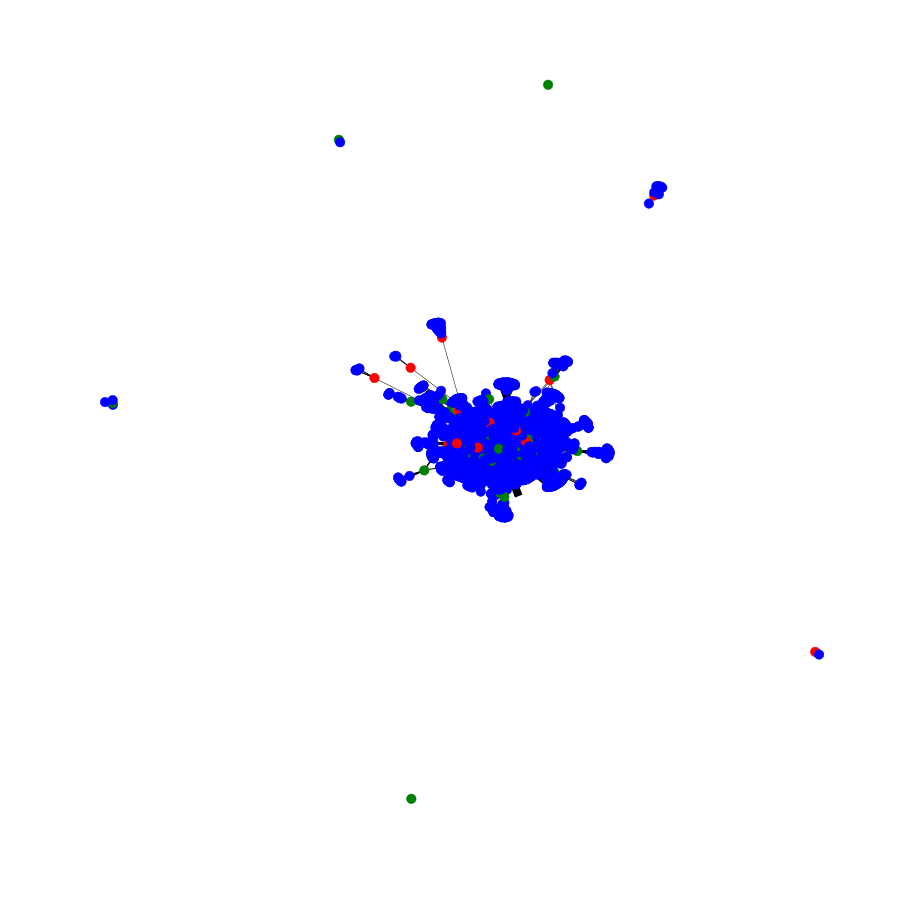

In [15]:
plt.figure(3,figsize=(12,12))

nx.draw(graph2, 
        node_color=node_colours, width=weights, node_size=90)
plt.show()

In [16]:
tweeter_count = Counter(tweeter_tagged[:,0])
tagged_count = Counter(tweeter_tagged[:,1])
top_10_tweeters = tweeter_count.most_common(10)
top_10_tagged = tagged_count.most_common(10)

In [17]:
print("Top 10 Tweeters: ", top_10_tweeters)

Top 10 Tweeters:  [('Uncle_SamCoco', 1618), ('mobi_ayubi', 1078), ('WarReporter1', 713), ('warrnews', 666), ('RamiAlLolah', 655), ('melvynlion', 642), ('MaghrabiArabi', 454), ('_IshfaqAhmad', 432), ('AsimAbuMerjem', 289), ('NaseemAhmed50', 252)]


In [18]:
print("Top 10 Receivers(tagged): ", top_10_tagged)

Top 10 Receivers(tagged):  [('RamiAlLolah', 573), ('Nidalgazaui', 339), ('WarReporter1', 256), ('7layers_', 116), ('ScotsmanInfidel', 79), ('sparksofirhabi3', 76), ('Conflicts', 72), ('DidyouknowVS', 72), ('MaghrebiQM', 72), ('Uncle_SamCoco', 70)]


## Network of Top 10 Tweeters and Top 10 Receivers in relation to each other

/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axe

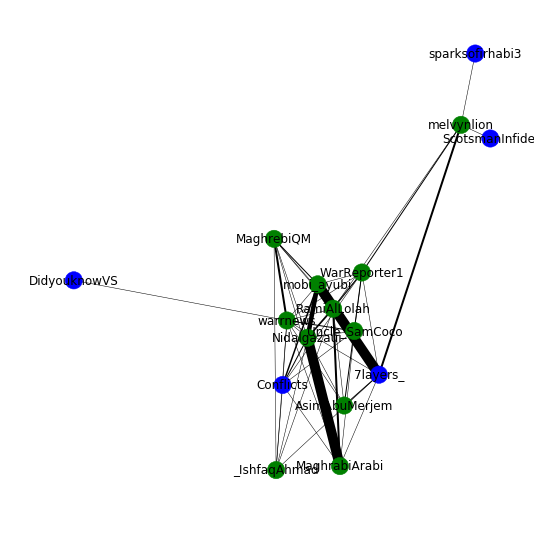

In [19]:
nodes_of_interest = ['Uncle_SamCoco', 'mobi_ayubi', 'RamiAlLolah', 'MaghrabiArabi', 'melvynlion', 'WarReporter1', '_IshfaqAhmad', 'warrnews', 'AsimAbuMerjem', 'NaseemAhmed', 'Nidalgazaui', '7layers_', 'ScotsmanInfidel', 'sparksofirhabi3', 'Conflicts', 'DidyouknowVS', 'MaghrebiQM']  # provided.
        
# Define get_nodes_and_nbrs()
def get_nodes(G, nodes_of_interest):
    """
    Returns a subgraph of the graph `G` with only the `nodes_of_interest` and their neighbors.
    """
    nodes_to_draw = []
    
    # Iterate over the nodes of interest
    for n in nodes_of_interest:
    
        # Append the nodes of interest to nodes_to_draw
        nodes_to_draw.append(n)
        
        # Iterate over all the neighbors of node n
        #for nbr in G.neighbors(n):
        
            # Append the neighbors of n to nodes_to_draw
            #nodes_to_draw.append(nbr)
            
    return G.subgraph(nodes_to_draw)

# Extract the subgraph with the nodes of interest: T_draw
T_draw = get_nodes(graph2, nodes_of_interest)

node_colours1=[]

for node in T_draw.nodes():
    if node in (set(tweeter_tagged[:,0]) & set(tweeter_tagged[:,1])):
        node_colours1.append('g') #tweeters & those tagged
    elif node in np.unique(tweeter_tagged[:,0]):
        node_colours1.append('r') #only tweeters
    elif node in np.unique(tweeter_tagged[:,1]):
        node_colours1.append('b') #only those who were tagged

# Draw the subgraph to the screen
plt.figure(figsize=(7,7))
nx.draw(T_draw, pos=nx.spring_layout(T_draw), node_color=node_colours1, with_labels=True, width=weights)
plt.show()

## Define Pro-ISIS

4 Parameters ranked by weight:
    1. Tagged #AmaqAgency - a well known ISIS affiliated news network
    2. Tagged #ISIS, #IS, #IslamicState
    3. Retweeted someone identified as pro-ISIS
    4. Tweeted around the time of an ISIS terrorist attack

Each parameter will have an associated multiplier in determining likelihood that the member is pro-ISIS.  If a member exhibits/falls into a category, that single instance will be muliplied by the multiplier.  All instances will be scored and added to determine whether an individual is pro-ISIS on a high, med or low scale.  For instance:

twitterUSER3 tagged AmaqAgency once, ISIS twice and retweeted a pro-ISIS user seven times.  twitterUSER3's score would be: 4(1) + 3(2) + 2(7) + 1(0) = 24

    4x #AmaqAgency
    3x #ISIS 
    2x RT a pro-ISIS user
    1x Tweeted around time of attack

In [20]:
hashtag_tagged = []

for record in all_tweets:
    match = re.findall(r'#\w*', record[1])
    if match != []:
        for hashtag in match:
            hashtag_tagged.append([record[0], hashtag[1:]])

hashtag_tagged = np.array(hashtag_tagged)
hashtag_tagged

array([['GunsandCoffee70', 'JN'],
       ['GunsandCoffee70', 'JN'],
       ['GunsandCoffee70', 'سبيل_النجاة'],
       ..., 
       ['nvor85j', 'Damascus'],
       ['ro34th', 'AmaqAgency'],
       ['ro34th', 'Ramadi']],
      dtype='<U304')

In [21]:
np.unique(hashtag_tagged)

array(['', '04_8_1437', '06230550_IS', ..., 'يوتيوب', 'کویرس', 'ব'],
      dtype='<U304')

In [22]:
df['hashtag'] = np.where(df.tweets.str.contains("#"), "yes", "no")

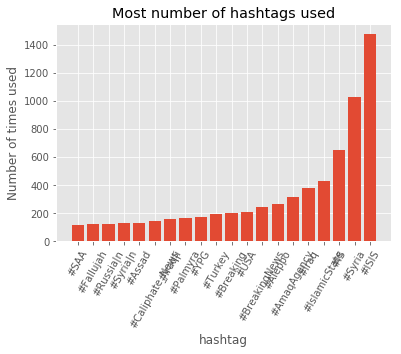

In [23]:
MyColumns = ['hashtag','cnt']
hashtagcount = pd.DataFrame(columns=MyColumns)

for index, row in df.iterrows():
    if '#' in row['tweets']:
        words = row['tweets'].split()
        for word in words:
            if word[0] == '#':
                hashtagcount.loc[len(hashtagcount)] = [word, 1]  # adding a row
                
hashtags = hashtagcount.groupby(['hashtag']).count().reset_index()
hashtags = hashtags.sort_values(by='cnt').tail(20)

x = hashtags['hashtag']
y = hashtags['cnt']
plt.xlabel('hashtag')
plt.ylabel('Number of times used')
plt.title('Most number of hashtags used')
plt.xticks(range(20), x, rotation=60)
plt.bar(range(20), y, label='Most hashtags used')
plt.show()

## Members who tag 'AmaqAgency,' an ISIS news outlet, are likely pro-ISIS

In [24]:
df['#Amaq'] = np.where(df.tweets.str.contains("#AmaqAgency"), '4', '0')

In [25]:
df2 = df[df['#Amaq'] == '4']
df2 = df2.drop_duplicates('username')

## Members who tag 'ISIS,' 'IS,' or 'IslamicState' are likely pro-ISIS

In [26]:
df['#ISIS'] = np.where(df.tweets.str.contains("#ISIS"), '3', 
                        np.where(df.tweets.str.contains("#IS"), '3', 
                                 np.where(df.tweets.str.contains("IslamicState"), '3', '0')))

In [27]:
df1 = df[df['#ISIS'] == '3']
df1 = df1.drop_duplicates('username')

In [28]:
pro_ISIS = pd.concat([df1['username'], df2['username']])
pro_ISIS = pro_ISIS.drop_duplicates()

## Members who retweet assumed pro-ISIS users are likely pro-ISIS

In [29]:
add_pro_ISIS = []
poss_pro_ISIS = []

for record in retweets:
    match = re.findall(r'@\w*', record[1])
    if match != []:
        for name in match:
            if (name[1:] in pro_ISIS.unique()) and (record[0] != name[1:]): 
                add_pro_ISIS.append(record[0]) #sender & receiver appended
            elif record[0] != name[1:]:
                poss_pro_ISIS.append(record[0]) #sender & receiver appended

#add_pro_ISIS = np.array(add_pro_ISIS) 
#poss_pro_ISIS = np.array(poss_pro_ISIS)

In [30]:
from collections import Counter
x = Counter(add_pro_ISIS)
dict(x)

{'06230550_IS': 2,
 '1515Ummah': 8,
 'AbuMusab_110': 6,
 'AbuNaseeha_03': 20,
 'Abu_Azzzam25': 45,
 'Abu_Ibn_Taha': 1,
 'Alwala_bara': 4,
 'AsimAbuMerjem': 43,
 'Bajwa47online': 6,
 'Baqiyah_Khilafa': 6,
 'BilalIbnRabah1': 3,
 'DabiqsweetsMan': 4,
 'EPlC24': 15,
 'FidaeeFulaani': 6,
 'Fidaee_Fulaani': 17,
 'Freedom_speech2': 6,
 'IbnKashmir_': 40,
 'Jazrawi_Joulan': 1,
 'Jazrawi_Saraqib': 11,
 'JohnsonsBot': 2,
 'JoinISNation102': 6,
 'MaghrabiArabi': 3,
 'MaghrebiQM': 2,
 'MaghrebiWM': 2,
 'ManKhalfahum': 3,
 'MilkSheikh2': 1,
 'Mountainjjoool': 10,
 'NaseemAhmed50': 43,
 'Nidalgazaui': 3,
 'QassamiMarwan': 7,
 'Suspend_Me_fags': 1,
 'Uncle_SamCoco': 43,
 'WarReporter1': 44,
 'WhiteCat_7': 2,
 'Witness_alHaqq': 22,
 'YazeedDhardaa25': 8,
 '_IshfaqAhmad': 17,
 '__alfresco__': 41,
 'abdlrhmn15': 3,
 'abuhanzalah10': 7,
 'abuhumayra4': 10,
 'abutariq040': 14,
 'abutariq041': 2,
 'alamreeki4': 6,
 'ansarakhilafa': 1,
 'baaqiya_01': 1,
 'darulhijrateyni': 10,
 'grezz10': 3,
 'ismailmahsud'

In [31]:
s = pd.Series(x, name='num_RT_proI_user')
s.index.name = 'username'
s = s.reset_index()

In [32]:
s['num_RT_proI_user'] = s['num_RT_proI_user'] * 2

In [33]:
add_pro_ISIS = np.unique(add_pro_ISIS)

df3 = pd.DataFrame(np.array(add_pro_ISIS))

pro_ISIS = pd.concat([pro_ISIS, df3])
pro_ISIS = pro_ISIS.drop_duplicates()

In [34]:
df = df.merge(s, how='outer', on='username')

In [35]:
df['num_RT_proI_user'] = df['num_RT_proI_user'].fillna(0)

## Members promoting ISIS around the time of an ISIS attack are likely pro-ISIS

In [36]:
df['time'].describe()

count               17410
unique              14164
top       4/14/2016 20:10
freq                   18
Name: time, dtype: object

/Users/Pewelix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  """
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=7,center=False).mean()
  


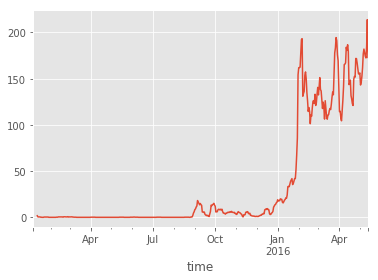

In [37]:
from scipy import interpolate
import seaborn as sns

df.time = pd.to_datetime(df.time)
perhr = df.set_index(df['time']).resample('D', how='count')
pd.rolling_mean(perhr, window=7).tweets['2015-01-06':].plot()

/Users/Pewelix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  """Entry point for launching an IPython kernel.
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=7,center=False).mean()
  


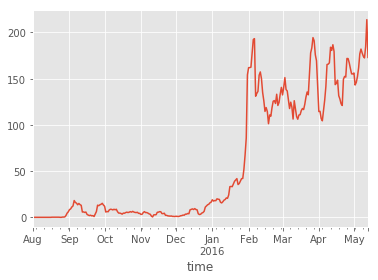

In [38]:
perhr = df.set_index(df['time']).resample('D', how='count')
pd.rolling_mean(perhr, window=7).tweets['2015-08-01':].plot()

/Users/Pewelix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  """Entry point for launching an IPython kernel.
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=7,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


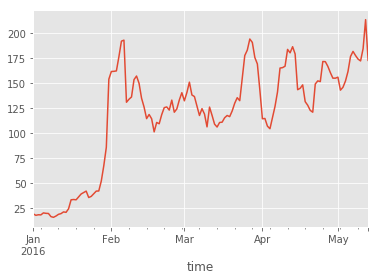

In [39]:
perhr = df.set_index(df['time']).resample('D', how='count')

pd.rolling_mean(perhr, window=7).tweets['2016-01-01':].plot()


In [40]:
df['tweet_after_event'] = np.where((df.time >= '2016-01-12') & (df.time <= '2016-01-15'), '1',
                                   np.where((df.time >= '2016-01-25') & (df.time <= '2016-01-26'), '1', 
                                            np.where((df.time >= '2016-01-30') & (df.time <= '2016-01-31'), '1',
                                                     np.where((df.time >= '2016-02-21') & (df.time <= '2016-02-22'), '1',
                                                              np.where((df.time >= '2016-03-22') & (df.time <= '2016-03-23'), '1',
                                                                       np.where((df.time >= '2016-04-19') & (df.time <= '2016-04-20'), '1',
                                                                                np.where((df.time >= '2016-04-30') & (df.time <= '2016-05-01'), '1',
                                                                                         np.where((df.time >= '2016-05-11') & (df.time <= '2016-05-12'), '1','0'))))))))

In [41]:
df4=df[df['tweet_after_event'] != 'None']
df4 = df4.drop_duplicates('username')

In [42]:
pro_ISIS = pd.concat([pro_ISIS, df4['username']])
pro_ISIS = pro_ISIS.drop_duplicates()

## ID Pro-ISIS members

In [43]:
pro_ISIS_users = pro_ISIS[0].tolist()

## Conduct network analysis on assumed Pro-ISIS members

In [44]:
in_set = []
not_in_set = []

for record in all_tweets:
    match = re.findall(r'@\w*', record[1])
    if match != []:
        for name in match:
            if (name[1:] in pro_ISIS[0].unique()) and (record[0] != name[1:]): 
                in_set.append([record[0], name[1:]]) #sender & receiver appended
            elif record[0] != name[1:]:
                not_in_set.append([record[0], name[1:]]) #sender & receiver appended

in_set = np.array(in_set) 
not_in_set = np.array(not_in_set)

In [45]:
graph3 = nx.Graph()

pro_ISIS_users = list(set(in_set[:,0]) | set(in_set[:,1]))
graph3.add_nodes_from(pro_ISIS_users, count=10)
node_colours = []

for node in graph3.nodes():
    if node in (set(in_set[:,0]) & set(in_set[:,1])):
        node_colours.append('g') #tweeters & those tagged
    elif node in np.unique(in_set[:,0]):
        node_colours.append('r') #only tweeters
    elif node in np.unique(in_set[:,1]):
        node_colours.append('b') #only those who were tagged

In [46]:
edges = {}
occurrence_count = Counter(map(tuple, in_set))
for (tweeter, tagged), count in occurrence_count.items():
    if (tagged, tweeter) in edges.keys():
        edges[(tagged, tweeter)] = edges[(tagged, tweeter)] + count
    else:
        edges[(tweeter, tagged)] = count
        
for (tweeter, tagged), count in edges.items():
    graph3.add_edge(tweeter, tagged, weight=count)
    
weights = [graph3.edge[u][v]['weight']/2 for u, v in graph3.edges()]

/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axe

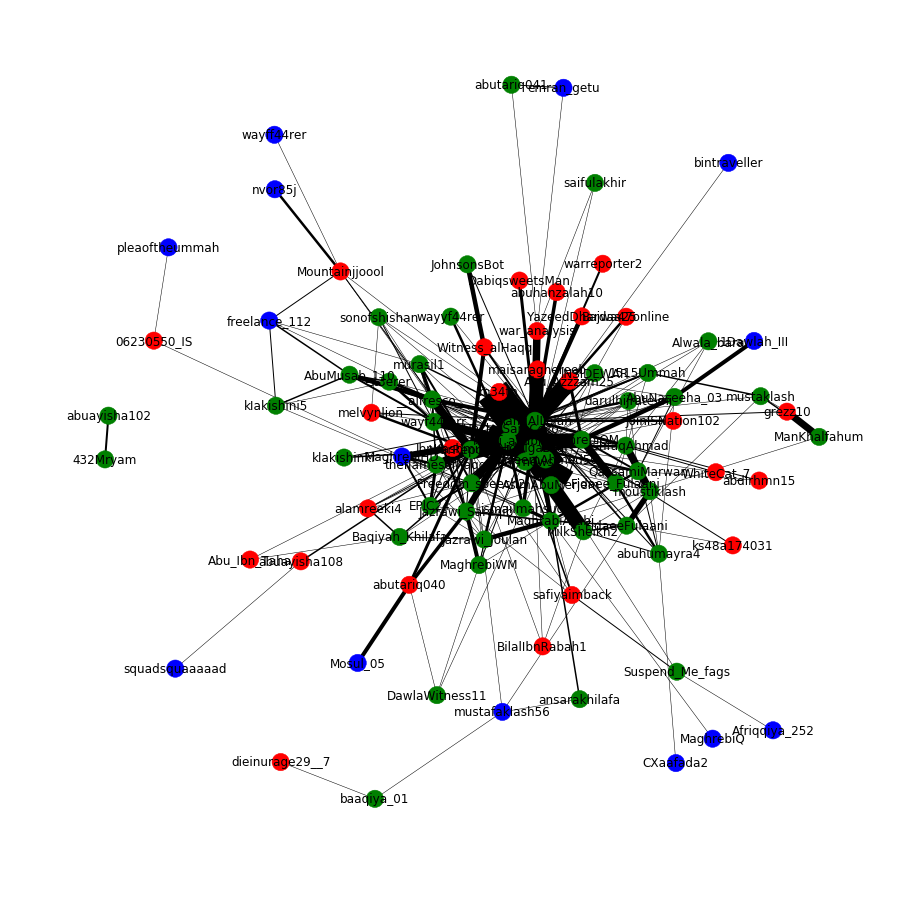

In [47]:
plt.figure(3,figsize=(12,12))

nx.draw(graph3, 
        node_color=node_colours, with_labels=True, width=weights)
plt.show()

In [48]:
degrees = [len(graph3.neighbors(n)) for n in graph3.nodes()]
degrees.sort()
print('Top 10 highest degrees: ', degrees[-10:])

Top 10 highest degrees:  [11, 12, 15, 17, 18, 19, 24, 29, 32, 51]


In [49]:
nodes_10_degrees = []

for n in graph3.nodes():
    if len(graph3.neighbors(n)) >= 10:
        nodes_10_degrees.append(n)
        
print(nodes_10_degrees)

['Freedom_speech2', 'RamiAlLolah', 'IbnKashmir_', 'mobi_ayubi', 'MaghrebiQM', 'Uncle_SamCoco', 'wayf44rerr', 'MaghrabiArabi', 'NaseemAhmed50', 'Nidalgazaui', '__alfresco__', 'Jazrawi_Saraqib', 'WarReporter1', 'QassamiMarwan', 'warrnews']


## Network of individuals connected to 10+ pro-ISIS twitter users in relation to each other

/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axe

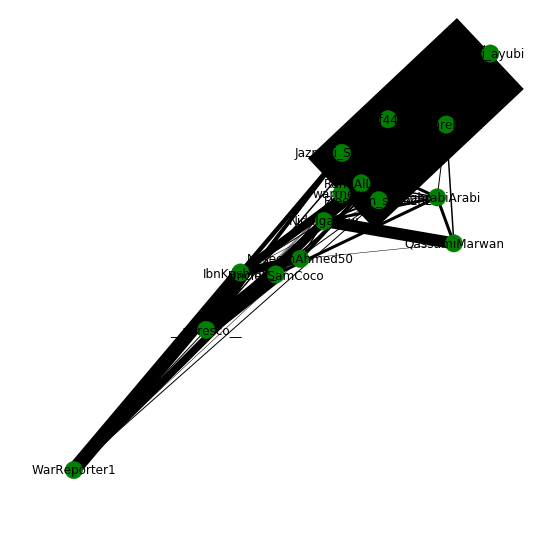

In [50]:
T_draw = get_nodes(graph3, nodes_10_degrees)

node_colours1=[]

for node in T_draw.nodes():
    if node in (set(tweeter_tagged[:,0]) & set(tweeter_tagged[:,1])):
        node_colours1.append('g') #tweeters & those tagged
    elif node in np.unique(tweeter_tagged[:,0]):
        node_colours1.append('r') #only tweeters
    elif node in np.unique(tweeter_tagged[:,1]):
        node_colours1.append('b') #only those who were tagged

# Draw the subgraph to the screen
plt.figure(figsize=(7,7))
nx.draw(T_draw, pos=nx.spring_layout(T_draw), node_color=node_colours1, with_labels=True, width=weights)
plt.show()

# Network of individuals connected to 10+ pro-ISIS twitter users

/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axe

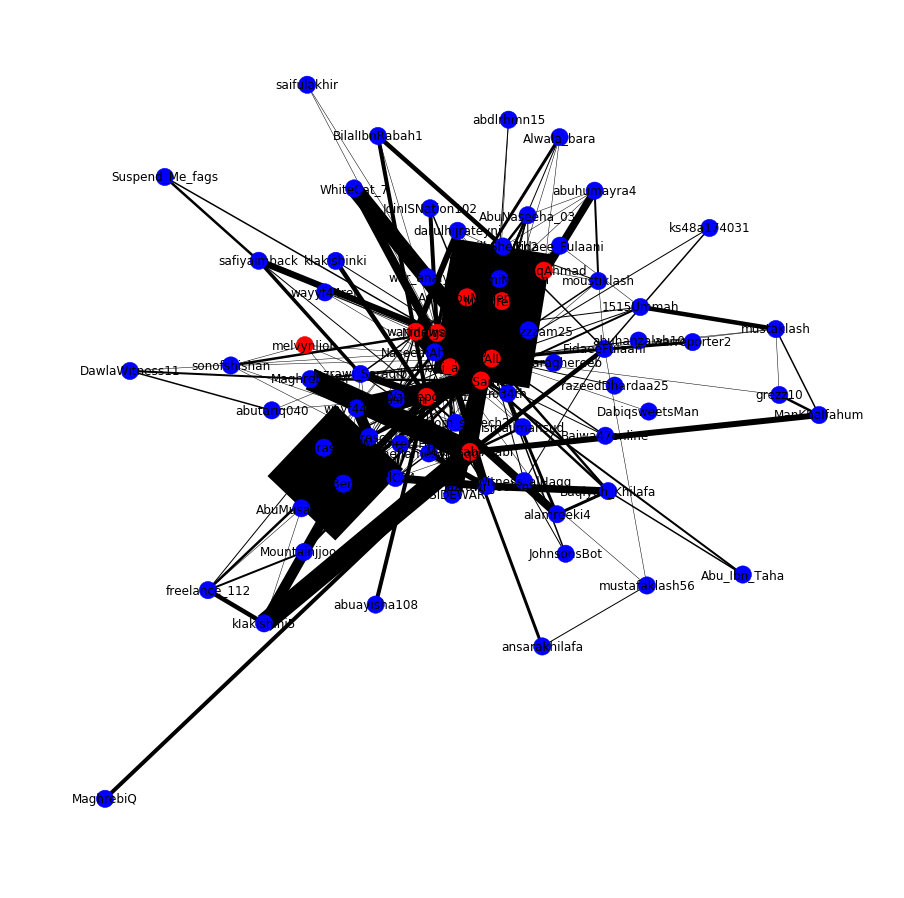

In [51]:
def get_nodes_and_nbrs(G, nodes_of_interest):
    """
    Returns a subgraph of the graph `G` with only the `nodes_of_interest` and their neighbors.
    """
    nodes_to_draw = []
    
    # Iterate over the nodes of interest
    for n in nodes_of_interest:
    
        # Append the nodes of interest to nodes_to_draw
        nodes_to_draw.append(n)
        
        
        # Iterate over all the neighbors of node n
        for nbr in G.neighbors(n):
        
            # Append the neighbors of n to nodes_to_draw
            nodes_to_draw.append(nbr)
            
    return G.subgraph(nodes_to_draw)

# Extract the subgraph with the nodes of interest: T_draw

T_draw = get_nodes_and_nbrs(graph3, nodes_10_degrees)

node_colours1=[]

for node in T_draw.nodes():
    if node in nodes_of_interest:
        node_colours1.append('r') #tweeters & those tagged
    else:
        node_colours1.append('b') #only those who were tagged

# Draw the subgraph to the screen
plt.figure(figsize=(12,12))

nx.draw(T_draw, pos=nx.spring_layout(T_draw), node_color=node_colours1, with_labels=True, width=weights)
plt.show()
#plt.savefig("Graph.png", format="PNG")

## Degree centrality

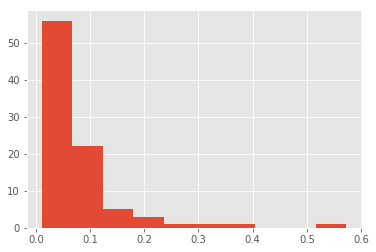

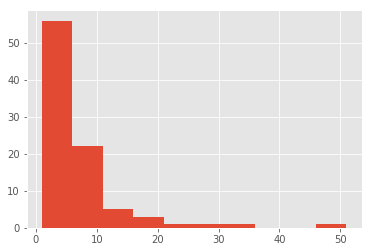

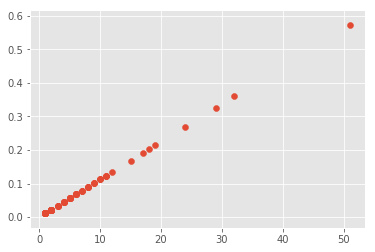

In [52]:
# Import matplotlib.pyplot
import matplotlib.pyplot as plt

# Compute the degree centrality of the Twitter network: deg_cent
deg_cent = nx.degree_centrality(graph3)

# Plot a histogram of the degree centrality distribution of the graph.
plt.figure()
plt.hist(list(deg_cent.values()))
plt.show()

# Plot a histogram of the degree distribution of the graph
plt.figure()
degrees = [len(graph3.neighbors(n)) for n in graph3.nodes()]
plt.hist(degrees)
plt.show()

# Plot a scatter plot of the centrality distribution and the degree distribution
plt.figure()
plt.scatter(x=degrees, y=list(deg_cent.values()))
plt.show()

## Betweenness centrality

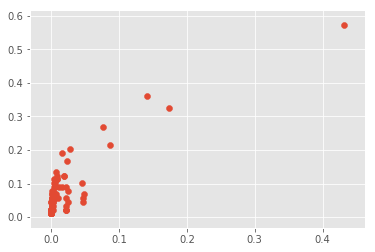

In [53]:
# Compute the betweenness centrality of T: bet_cen
bet_cen = nx.betweenness_centrality(graph3)

# Compute the degree centrality of T: deg_cen
deg_cen = nx.degree_centrality(graph3)

# Create a scatter plot of betweenness centrality and degree centrality
plt.scatter(x=list(bet_cen.values()), y=list(deg_cen.values()))

# Display the plot
plt.show()

## Find node with highest degree centrality

In [54]:
# Define find_nodes_with_highest_deg_cent()
def find_nodes_with_highest_deg_cent(G):

    # Compute the degree centrality of G: deg_cent
    deg_cent = nx.degree_centrality(G)
    
    # Compute the maximum degree centrality: max_dc
    max_dc = max(list(deg_cent.values()))
    
    nodes = set()
    
    # Iterate over the degree centrality dictionary
    for k, v in deg_cent.items():
    
        # Check if the current value has the maximum degree centrality
        if v == max_dc:
        
            # Add the current node to the set of nodes
            nodes.add(k)
            
    return nodes
    
# Find the node(s) that has the highest degree centrality in T: top_dc
top_dc = find_nodes_with_highest_deg_cent(graph3)
print(top_dc)

{'RamiAlLolah'}


## Find node with highest betweenness centrality

In [55]:
# Define find_node_with_highest_bet_cent()
def find_node_with_highest_bet_cent(G):

    # Compute betweenness centrality: bet_cent
    bet_cent = nx.betweenness_centrality(G)
    
    # Compute maximum betweenness centrality: max_bc
    max_bc = max(list(bet_cent.values()))
    
    nodes = set()
    
    # Iterate over the betweenness centrality dictionary
    for k, v in bet_cent.items():
    
        # Check if the current value has the maximum betweenness centrality
        if v == max_bc:
        
            # Add the current node to the set of nodes
            nodes.add(k)
            
    return nodes

# Use that function to find the node(s) that has the highest betweenness centrality in the network: top_bc
top_bc = find_node_with_highest_bet_cent(graph3)
print(top_bc)

{'RamiAlLolah'}


## Calculate maximal cliques

In [56]:
# Calculate the maximal cliques in G: cliques
cliques = nx.find_cliques(graph3)

# Count and print the number of maximal cliques in G
print(len(list(cliques)))

140


In [57]:
# Define maximal_cliques()
def maximal_cliques(G, size):
    """
    Finds all maximal cliques in graph `G` that are >= size `size`.
    """
    mcs = []
    for clique in nx.find_cliques(G):
        if len(clique) >= size:
            mcs.append(clique)
    return mcs

maximal_cliques(graph3, 7)

[['RamiAlLolah',
  'Nidalgazaui',
  'Uncle_SamCoco',
  'WarReporter1',
  'mobi_ayubi',
  'NaseemAhmed50',
  'warrnews']]

## ID top 10 pairs of users

In [58]:
# Import necessary modules
from itertools import combinations
from collections import defaultdict

# Initialize the defaultdict: recommended
recommended = defaultdict(int)

# Iterate over all the nodes in G
for n, d in graph3.nodes(data=True):

    # Iterate over all possible triangle relationship combinations
    for n1, n2 in combinations(graph3.neighbors(n), 2):
    
        # Check whether n1 and n2 do not have an edge
        if not graph3.has_edge(n1, n2):
        
            # Increment recommended
            recommended[(n1, n2)] += 1

# Identify the top 10 pairs of users
all_counts = sorted(recommended.values())
top10_pairs = [pair for pair, count in recommended.items() if count > all_counts[-10]]
print(top10_pairs)


[('RamiAlLolah', 'Jazrawi_Joulan'), ('Nidalgazaui', 'Jazrawi_Joulan'), ('MaghrabiArabi', 'mobi_ayubi')]


## ID members with the most followers

In [59]:
df = pro_ISIS.merge(df, how='outer', left_on=0, right_on='username')

In [60]:
df['followers'].describe()

count    17410.000000
mean      3975.076680
std       8674.378495
min         16.000000
25%        266.000000
50%        928.000000
75%       1791.000000
max      34692.000000
Name: followers, dtype: float64

In [61]:
df_most_followers = df.loc[df['followers'] >= 1500]
df_most_followers = df_most_followers.drop_duplicates('username')
df_most_followers = df_most_followers.sort_values('followers')
df_most_followers[['username', 'followers']]

username  followers
9134      _IshfaqAhmad       1520
7731     Uncle_SamCoco       1532
6797     QassamiMarwan       1593
10709     WarReporter1       1748
11988      klakishinki       1791
7143        MaghrebiQM       2021
1158     NaseemAhmed50       2121
12241  Freedom_speech2       3233
14333      Nidalgazaui       4187
5606          warrnews       7152
2923       RamiAlLolah      29209

/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axe

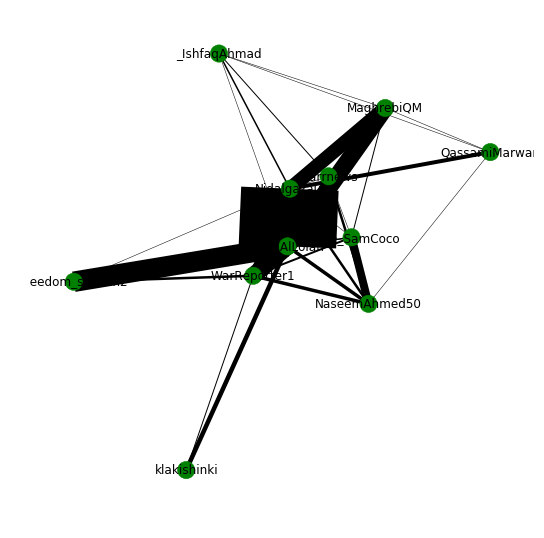

In [62]:
nodes_1500_followers = df_most_followers['username'].tolist()

T_draw = get_nodes(graph3, nodes_1500_followers)

node_colours1=[]

for node in T_draw.nodes():
    if node in (set(in_set[:,0]) & set(in_set[:,1])):
        node_colours1.append('g') #tweeters & those tagged
    elif node in np.unique(in_set[:,0]):
        node_colours1.append('r') #only tweeters
    elif node in np.unique(in_set[:,1]):
        node_colours1.append('b') #only those who were tagged

# Draw the subgraph to the screen
plt.figure(figsize=(7,7))
nx.draw(T_draw, pos=nx.spring_layout(T_draw), node_color=node_colours1, with_labels=True, width=weights)
plt.show()

## ID users posting the most tweets

In [63]:
df['numberstatuses'].describe()

count    17410.000000
mean      4760.787651
std       7015.967275
min          1.000000
25%        207.000000
50%        908.000000
75%       6865.000000
max      33091.000000
Name: numberstatuses, dtype: float64

In [64]:
df_most_tweets = df.loc[df['numberstatuses'] >= 6500]
df_most_tweets = df_most_tweets.drop_duplicates('username')
df_most_tweets = df_most_tweets.sort_values('numberstatuses')
df_most_tweets[['username', 'numberstatuses']]

username  numberstatuses
6001          warrnews            6629
4550        mobi_ayubi            6707
8625     Uncle_SamCoco            6743
12241  Freedom_speech2            9180
8823      _IshfaqAhmad           12002
2923       RamiAlLolah           16688
12434      IbnKashmir_           28832
14829           ro34th           32875

/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axe

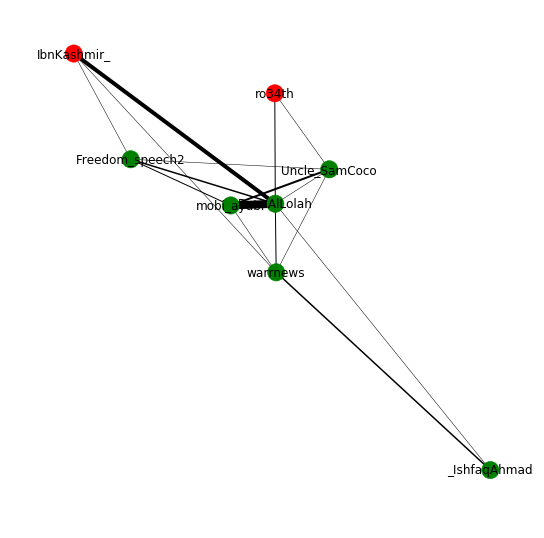

In [65]:
nodes_6500_statuses = df_most_tweets['username'].tolist()

T_draw = get_nodes(graph3, nodes_6500_statuses)

node_colours1=[]

for node in T_draw.nodes():
    if node in (set(in_set[:,0]) & set(in_set[:,1])):
        node_colours1.append('g') #tweeters & those tagged
    elif node in np.unique(in_set[:,0]):
        node_colours1.append('r') #only tweeters
    elif node in np.unique(in_set[:,1]):
        node_colours1.append('b') #only those who were tagged

# Draw the subgraph to the screen
plt.figure(figsize=(7,7))
nx.draw(T_draw, pos=nx.spring_layout(T_draw), node_color=node_colours1, with_labels=True, width=weights)
plt.show()

## Most influential pro-ISIS users based on connectedness, number of followers, and number of statuses

In [66]:
df['#Amaq'] = df['#Amaq'].astype(int)
df['#ISIS'] = df['#ISIS'].astype(int)
df['num_RT_proI_user'] = df['num_RT_proI_user'].astype(int)
df['tweet_after_event'] = df['tweet_after_event'].astype(int)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17410 entries, 0 to 17409
Data columns (total 14 columns):
0                    17410 non-null object
name                 17410 non-null object
username             17410 non-null object
description          17410 non-null object
location             17410 non-null object
followers            17410 non-null int64
numberstatuses       17410 non-null int64
time                 17410 non-null datetime64[ns]
tweets               17410 non-null object
hashtag              17410 non-null object
#Amaq                17410 non-null int64
#ISIS                17410 non-null int64
num_RT_proI_user     17410 non-null int64
tweet_after_event    17410 non-null int64
dtypes: datetime64[ns](1), int64(6), object(7)
memory usage: 2.0+ MB


In [68]:
x = df.groupby(['username'])[["#Amaq", "#ISIS", "num_RT_proI_user", "tweet_after_event"]].sum()
x['pro_ISIS_score'] = x.sum(axis=1)
y = x[['pro_ISIS_score']]
y = y.reset_index()

In [69]:
df = df.merge(y, how='outer', on='username')

In [70]:
df['pro_ISIS_score'].describe()

count     17410.000000
mean     101547.294026
std      211381.718115
min           0.000000
25%         854.000000
50%        4529.000000
75%       96798.000000
max      803625.000000
Name: pro_ISIS_score, dtype: float64

In [71]:
df_proISISscore = df.loc[df['pro_ISIS_score'] >= 10000]
df_proISISscore = df_proISISscore.drop_duplicates('username')
df_proISISscore = df_proISISscore.sort_values('pro_ISIS_score')
df_proISISscore[['username', 'pro_ISIS_score']]

username  pro_ISIS_score
9567   Fidaee_Fulaani           10146
2088     Abu_Azzzam25           10785
12434     IbnKashmir_           18588
822     AsimAbuMerjem           20328
14829          ro34th           22331
15488    __alfresco__           23793
8823     _IshfaqAhmad           24173
1158    NaseemAhmed50           28733
10235    WarReporter1           96798
7243    Uncle_SamCoco          136030
5606         warrnews          443873
4550       mobi_ayubi          803625

In [92]:
nodes_of_interest1 = ['RamiAlLolah',
  'Nidalgazaui',
  'Uncle_SamCoco',
  'WarReporter1',
  'mobi_ayubi',
  'NaseemAhmed50',
  'warrnews',
  '_IshfaqAhmad',
  'ro34th',
  'IbnKashmir_']

x=[]

for n in nodes_of_interest1:
    x.append([n, len(graph3.neighbors(n))])
        
df4 = pd.DataFrame(np.array(x).reshape(10,2))

In [93]:
df5 = df.loc[df['username'].isin(nodes_of_interest1)]
df5 = df5.drop_duplicates('username')
df5 = df5[['username', 'followers', 'numberstatuses', 'pro_ISIS_score']]

In [94]:
df6 = df5.merge(df4, left_on='username', right_on=0)
del df6[0]

In [95]:
df6.columns = ['username', 'total followers', 'total statuses', 'pro_ISIS_score', 'total pro-ISIS nodes']
df6 = df6.sort_values('pro_ISIS_score', ascending=False)

In [96]:
columnsTitles=['username', 'total followers', 'total statuses', 'total pro-ISIS nodes', 'pro_ISIS_score']
df6=df6.reindex(columns=columnsTitles)

In [97]:
df6

username  total followers  total statuses total pro-ISIS nodes  \
2     mobi_ayubi              693            6707                   18   
3       warrnews             7152            5929                   17   
4  Uncle_SamCoco             1273            1820                   24   
6   WarReporter1              498             164                   29   
0  NaseemAhmed50             2121            4992                   11   
5   _IshfaqAhmad             1402           12002                    9   
9         ro34th             1365           32875                    4   
7    IbnKashmir_              122           28832                   10   
8    Nidalgazaui             4187            5437                   32   
1    RamiAlLolah            29209           16688                   51   

   pro_ISIS_score  
2          803625  
3          443873  
4          136030  
6           96798  
0           28733  
5           24173  
9           22331  
7           18588  
8            2791  
1            1606

## Pro-ISIS network 

/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axe

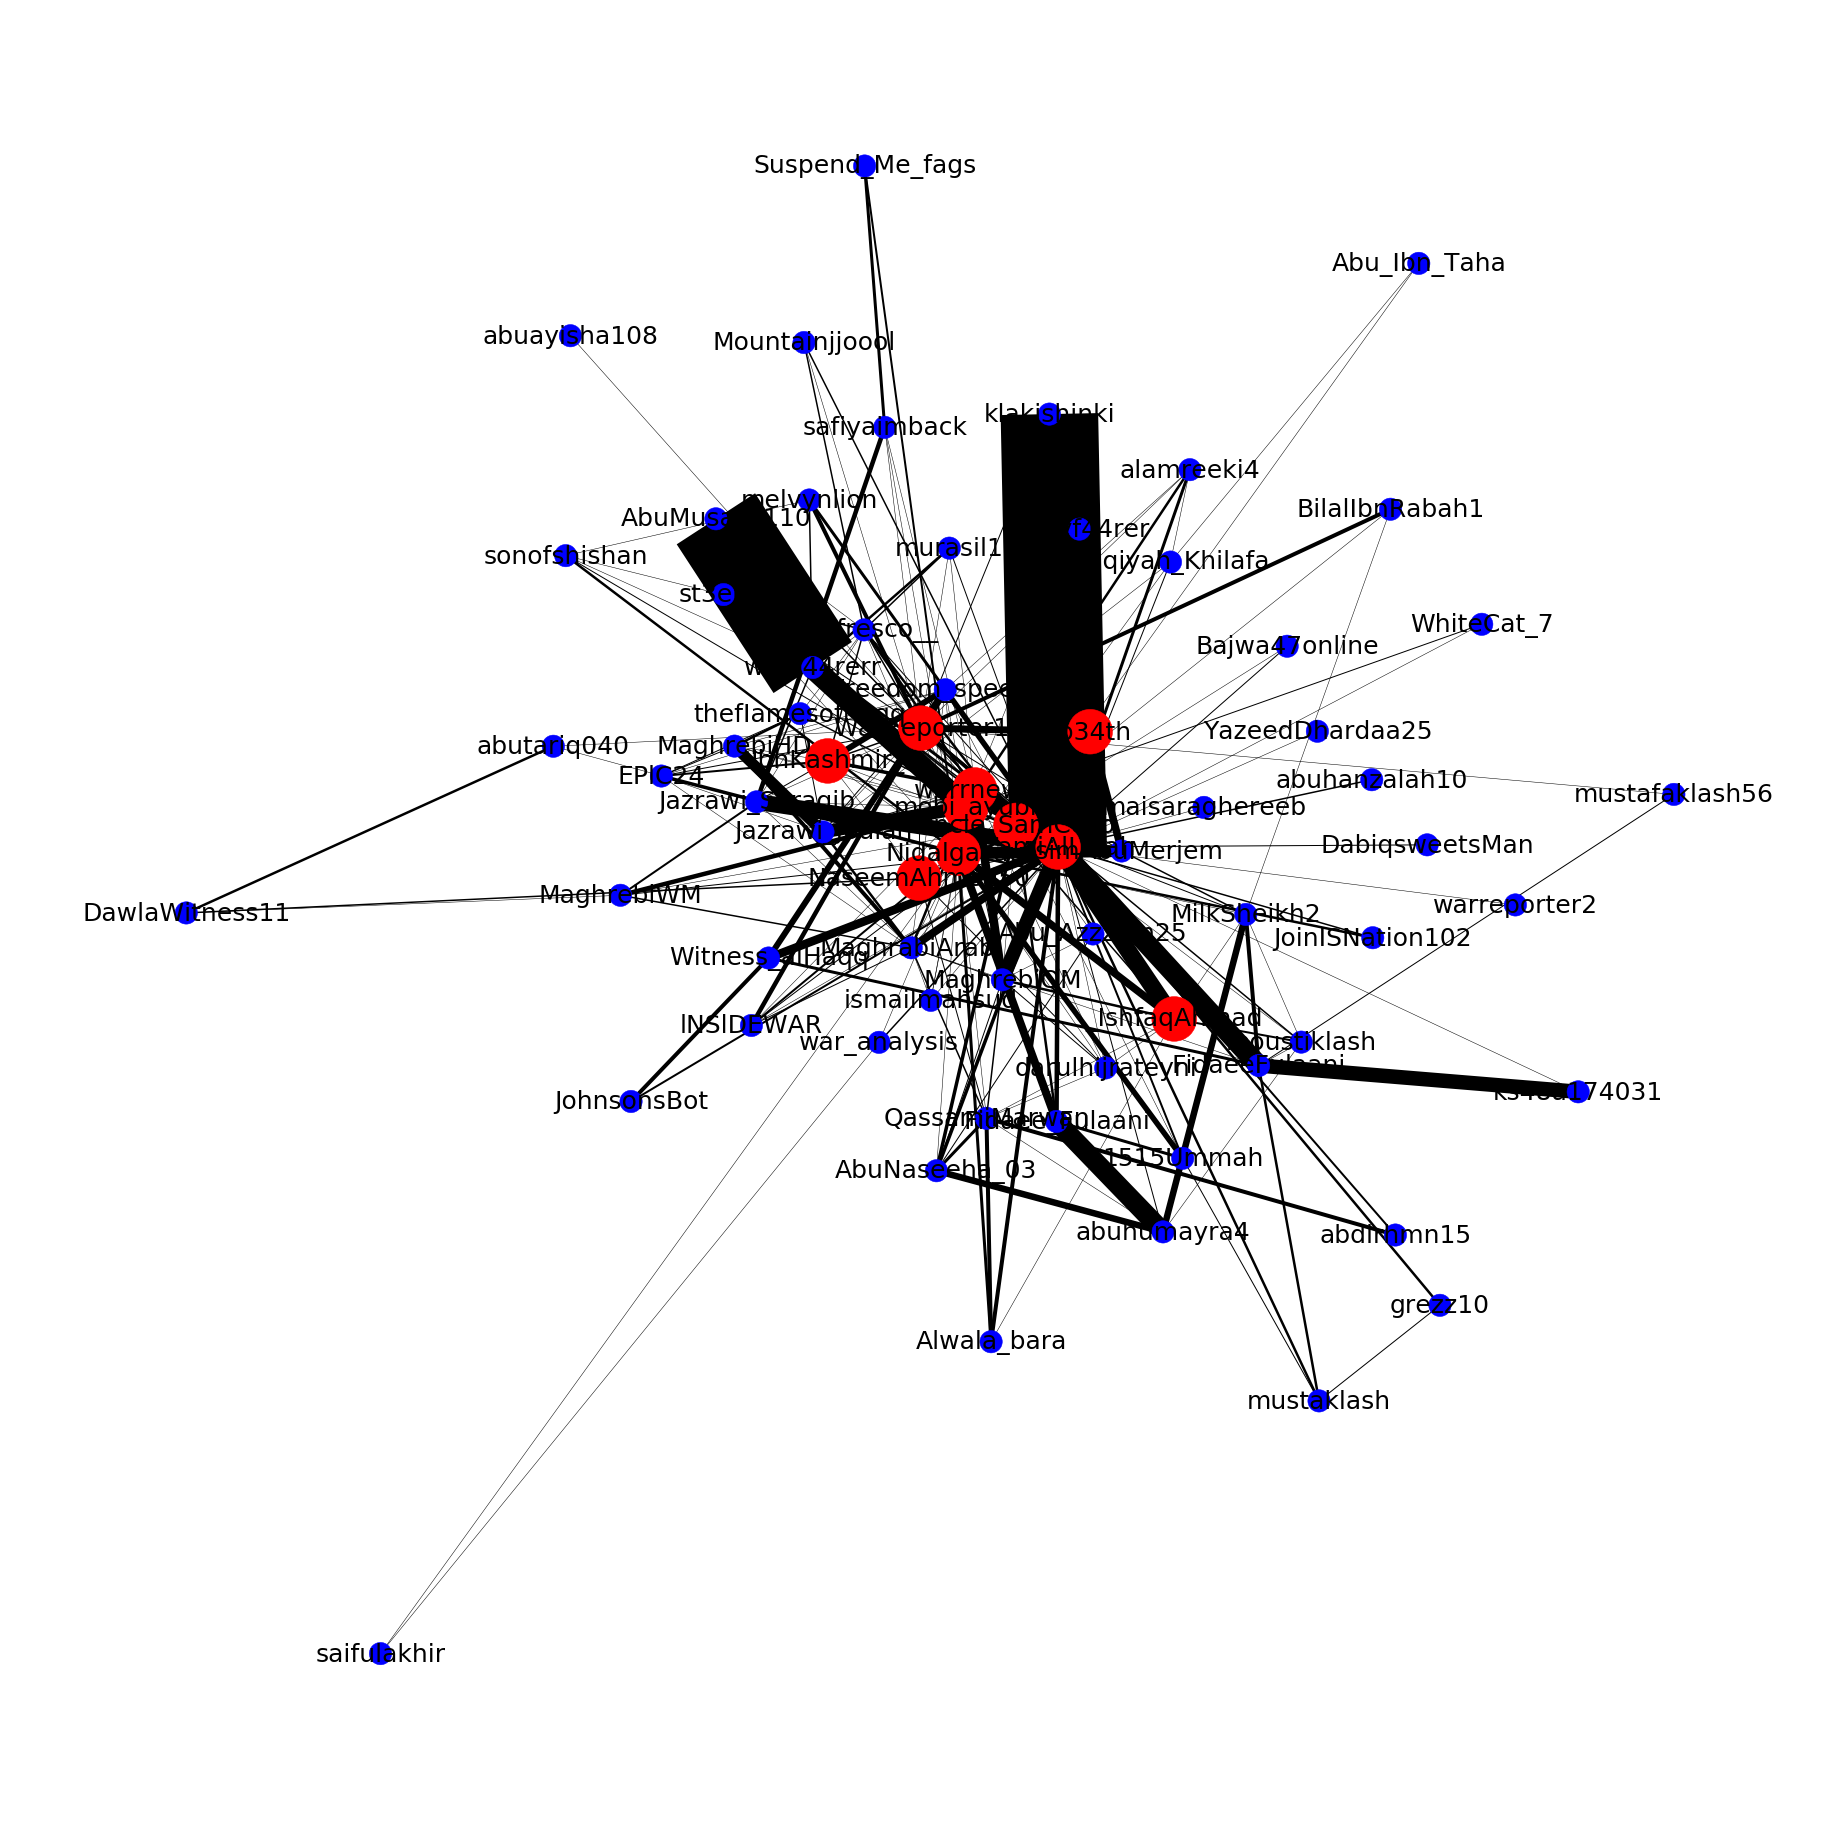

In [114]:
T_draw = get_nodes_and_nbrs(graph3, nodes_of_interest1)

node_colours1=[]
size=[]

for node in T_draw.nodes():
    if node in nodes_of_interest1:
        node_colours1.append('r') #tweeters & those tagged
        size.append(2000)
    else:
        node_colours1.append('b') #only those who were tagged
        size.append(500)

# Draw the subgraph to the screen
plt.figure(figsize=(25,25))

nx.draw(T_draw, pos=nx.spring_layout(T_draw), node_color=node_colours1, with_labels=True, font_size=25, node_size = size, width=weights)
plt.show()

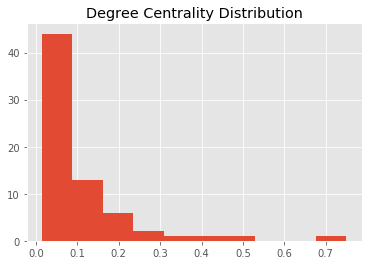

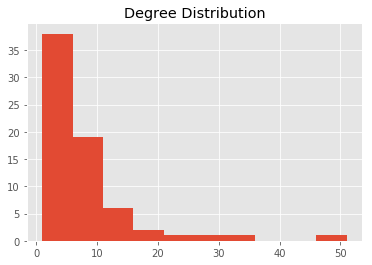

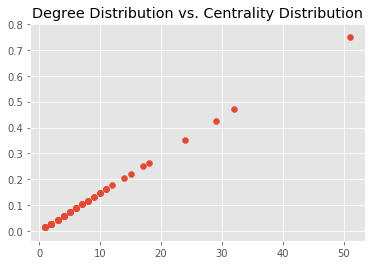

In [115]:
# Import matplotlib.pyplot
import matplotlib.pyplot as plt

# Compute the degree centrality of the Twitter network: deg_cent
deg_cent = nx.degree_centrality(T_draw)

# Plot a histogram of the degree centrality distribution of the graph.
plt.figure()
plt.hist(list(deg_cent.values()))
plt.title('Degree Centrality Distribution')
plt.show()

# Plot a histogram of the degree distribution of the graph
plt.figure()
degrees = [len(T_draw.neighbors(n)) for n in T_draw.nodes()]
plt.hist(degrees)
plt.title('Degree Distribution')
plt.show()

# Plot a scatter plot of the centrality distribution and the degree distribution
plt.figure()
plt.scatter(x=degrees, y=list(deg_cent.values()))
plt.title('Degree Distribution vs. Centrality Distribution')
plt.show()

## Betweenness centrality

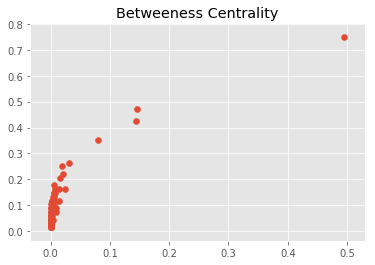

In [116]:
# Compute the betweenness centrality of T: bet_cen
bet_cen = nx.betweenness_centrality(T_draw)

# Compute the degree centrality of T: deg_cen
deg_cen = nx.degree_centrality(T_draw)

# Create a scatter plot of betweenness centrality and degree centrality
plt.scatter(x=list(bet_cen.values()), y=list(deg_cen.values()))
plt.title('Betweeness Centrality')
# Display the plot
plt.show()

In [122]:
# Define find_nodes_with_highest_deg_cent()
def find_nodes_with_highest_deg_cent(G):

    # Compute the degree centrality of G: deg_cent
    deg_cent = nx.degree_centrality(G)
    
    # Compute the maximum degree centrality: max_dc
    max_dc = max(list(deg_cent.values()))
    
    nodes = set()
    
    # Iterate over the degree centrality dictionary
    for k, v in deg_cent.items():
    
        # Check if the current value has the maximum degree centrality
        if v == max_dc:
        
            # Add the current node to the set of nodes
            nodes.add(k)
            
    return nodes
    
# Find the node(s) that has the highest degree centrality in T: top_dc
top_dc = find_nodes_with_highest_deg_cent(graph3)
print(top_dc)

{'RamiAlLolah'}


In [123]:
# Define find_node_with_highest_bet_cent()
def find_node_with_highest_bet_cent(G):

    # Compute betweenness centrality: bet_cent
    bet_cent = nx.betweenness_centrality(G)
    
    # Compute maximum betweenness centrality: max_bc
    max_bc = max(list(bet_cent.values()))
    
    nodes = set()
    
    # Iterate over the betweenness centrality dictionary
    for k, v in bet_cent.items():
    
        # Check if the current value has the maximum betweenness centrality
        if v == max_bc:
        
            # Add the current node to the set of nodes
            nodes.add(k)
            
    return nodes

# Use that function to find the node(s) that has the highest betweenness centrality in the network: top_bc
top_bc = find_node_with_highest_bet_cent(graph3)
print(top_bc)

{'RamiAlLolah'}


## Pro-ISIS network extended to include twitter users they have tagged in a pro-ISIS tweet

/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axe

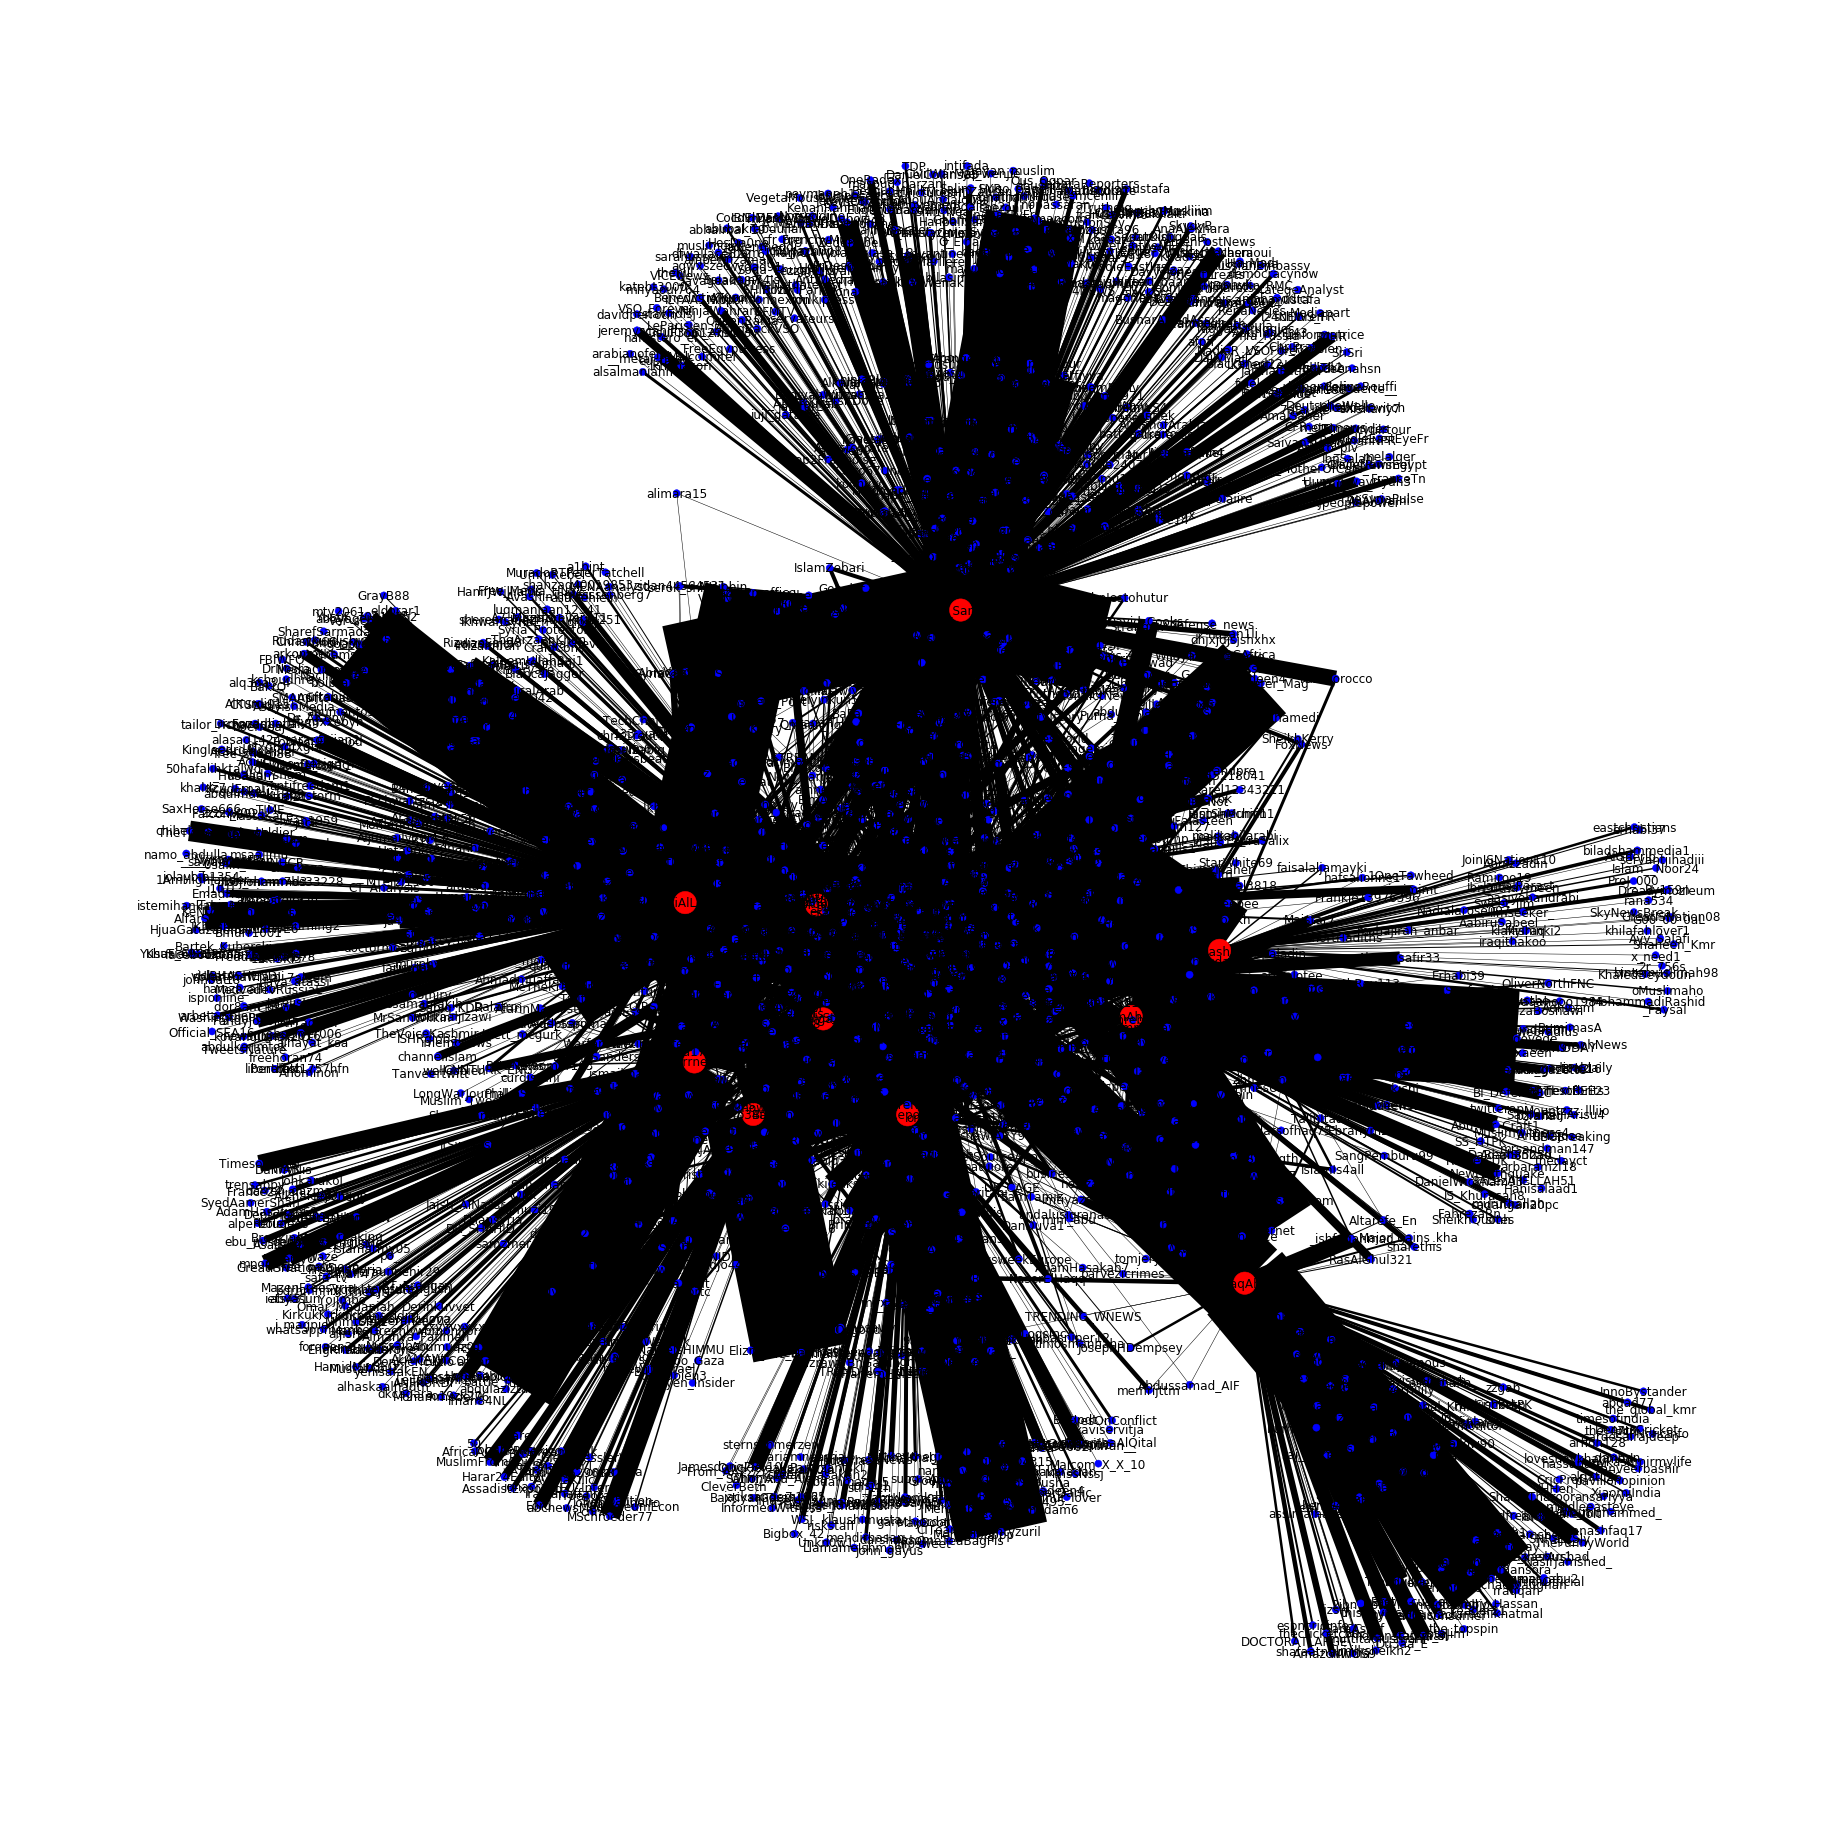

In [121]:
T_draw = get_nodes_and_nbrs(graph2, nodes_of_interest1)

node_colours1=[]
size=[]

for node in T_draw.nodes():
    if node in nodes_of_interest1:
        node_colours1.append('r') #tweeters & those tagged
        size.append(500)
    else:
        node_colours1.append('b') #only those who were tagged
        size.append(50)

# Draw the subgraph to the screen
plt.figure(figsize=(25,25))

nx.draw(T_draw, node_color=node_colours1, with_labels=True, node_size = size, width=weights)
plt.show()

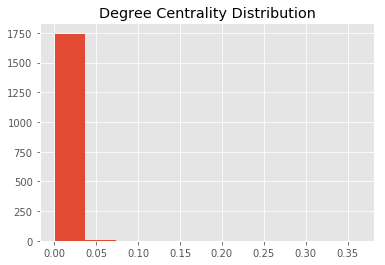

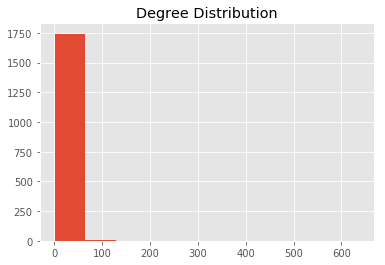

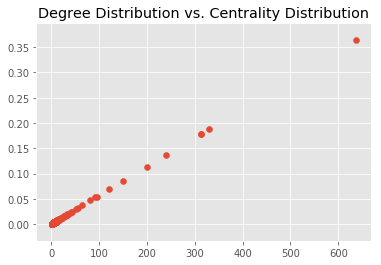

In [118]:
# Import matplotlib.pyplot
import matplotlib.pyplot as plt

# Compute the degree centrality of the Twitter network: deg_cent
deg_cent = nx.degree_centrality(T_draw)

# Plot a histogram of the degree centrality distribution of the graph.
plt.figure()
plt.hist(list(deg_cent.values()))
plt.title('Degree Centrality Distribution')
plt.show()

# Plot a histogram of the degree distribution of the graph
plt.figure()
degrees = [len(T_draw.neighbors(n)) for n in T_draw.nodes()]
plt.hist(degrees)
plt.title('Degree Distribution')
plt.show()

# Plot a scatter plot of the centrality distribution and the degree distribution
plt.figure()
plt.scatter(x=degrees, y=list(deg_cent.values()))
plt.title('Degree Distribution vs. Centrality Distribution')
plt.show()

## Betweenness centrality

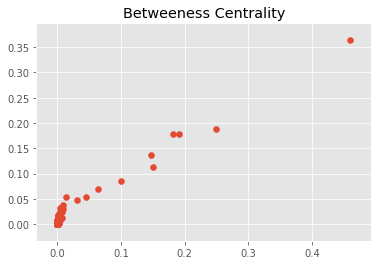

In [119]:
# Compute the betweenness centrality of T: bet_cen
bet_cen = nx.betweenness_centrality(T_draw)

# Compute the degree centrality of T: deg_cen
deg_cen = nx.degree_centrality(T_draw)

# Create a scatter plot of betweenness centrality and degree centrality
plt.scatter(x=list(bet_cen.values()), y=list(deg_cen.values()))
plt.title('Betweeness Centrality')
# Display the plot
plt.show()